In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import scipy.signal
from scipy.signal import convolve
import torch
import torch.nn
from torch.utils.data import Dataset, DataLoader

In [ ]:
def findGradient(img, ksize=5, sigma=1):
    G = cv2.getGaussianKernel(ksize, sigma)
    G = G @ G.T
    fx = np.array([[1, -1]])
    fy = fx.T
    Gx = scipy.signal.convolve2d(G, fx, 'same', 'symm')[:, 1:]
    Gy = scipy.signal.convolve2d(G, fy, 'same', 'symm')[1:, :]
    Ix = scipy.signal.convolve2d(img, Gx, 'same', 'symm')
    Iy = scipy.signal.convolve2d(img, Gy, 'same', 'symm')
    return Ix, Iy


def select_win(lst, slice1, slice2):
    return [item[slice1, slice2] for item in lst]


def interp2_img(img, xq, yq):
    """2D interpolation on images
    Args:
    img (h, w, 3): RGB image
    xq (n,): x coordinate of query points
    yq (n,): y coordinate of query points

    Returns:
    interp_val (n, 3): interpolated values for 3 channels
    """ 
    h, w = img.shape[:2]
    assert xq.shape == yq.shape, 'query coordinates Xq Yq should have same shape'
    x_floor = np.floor(xq).astype(np.int32)
    y_floor = np.floor(yq).astype(np.int32)
    x_ceil = np.ceil(xq).astype(np.int32)
    y_ceil = np.ceil(yq).astype(np.int32)

    x_floor[x_floor < 0] = 0
    y_floor[y_floor < 0] = 0
    x_ceil[x_ceil < 0] = 0
    y_ceil[y_ceil < 0] = 0

    x_floor[x_floor >= w-1] = w-1
    y_floor[y_floor >= h-1] = h-1
    x_ceil[x_ceil >= w-1] = w-1
    y_ceil[y_ceil >= h-1] = h-1

    v1 = img[y_floor, x_floor]
    v2 = img[y_floor, x_ceil]
    v3 = img[y_ceil, x_floor]
    v4 = img[y_ceil, x_ceil]

    lh = yq - y_floor
    lw = xq - x_floor
    hh = 1 - lh
    hw = 1 - lw

    w1 = (hh * hw)
    w2 = (hh * lw)
    w3 = (lh * hw)
    w4 = (lh * lw)

    interp_val = v1 * w1 + w2 * v2 + w3 * v3 + w4 * v4

    return interp_val


def optical_flow(img1, img2, ksize, sigma):
    Jx, Jy = findGradient(img2, ksize, sigma)
    It = img2 - img1
    A = np.hstack((Jx.reshape(-1, 1), Jy.reshape(-1, 1)))
    b = -It.reshape(-1, 1)
    res = np.linalg.solve(A.T @ A, A.T @ b)
    return res[0, 0], res[1, 0]


def get_new_img(img, dx, dy):
    x, y = np.meshgrid(np.arange(img.shape[1]), np.arange(img.shape[0]))
    new_x, new_y = x + dx, y + dy
    return interp2_img(img, new_x, new_y)

Optical flow on the Teddy bear

In [ ]:
img1 = plt.imread('frame10.png')
img2 = plt.imread('frame11.png')

1.1774351277779167 -0.1948396736369556


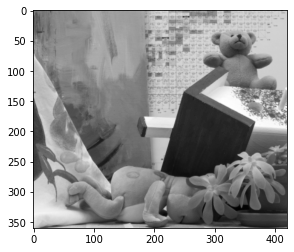

1.141532521512573 0.016558576023086927


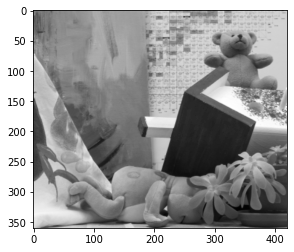

1.0104597581650963 0.16161207764867244


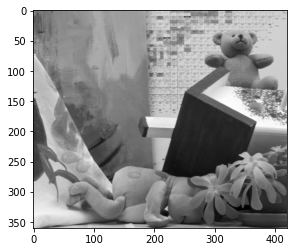

0.5439085378396573 0.17935671399725905


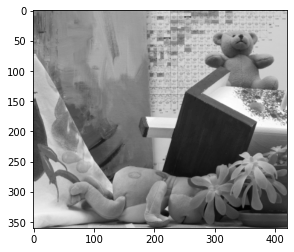

0.10000512797571441 0.011207404510372467


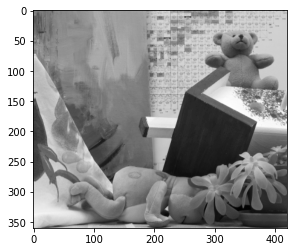

0.01934355886661664 0.0021624522521068406


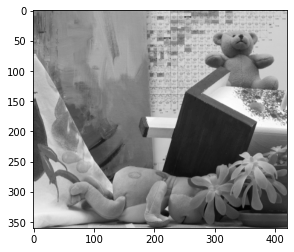

0.003756436207616125 0.00038546974394738416


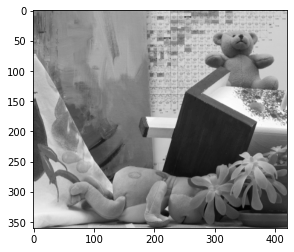

0.0007304823894119791 8.057660572367388e-05


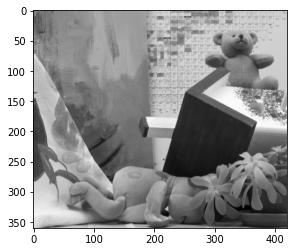

0.00014199809172501984 1.448518944491958e-05


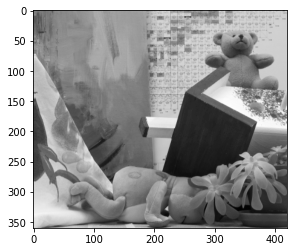

2.7618789982756245e-05 3.0530293806838593e-06


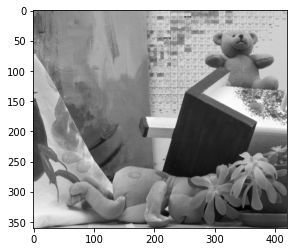

5.368899025774207e-06 5.459374617492433e-07


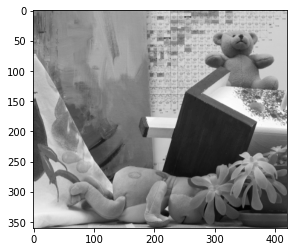

1.0442856533618902e-06 1.1577290447930828e-07


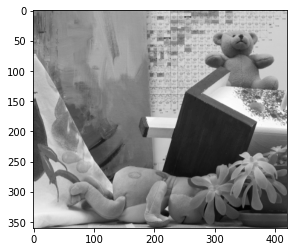

2.029977895881052e-07 2.0573553763416392e-08


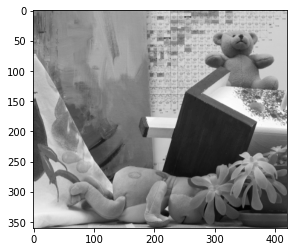

3.94852645006142e-08 4.3912106756419335e-09


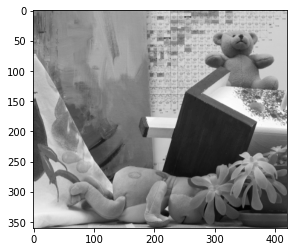

7.675335511406613e-09 7.751118079591933e-10


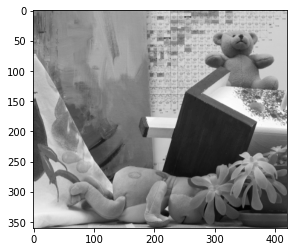

1.4929681962297944e-09 1.6658883786397137e-10


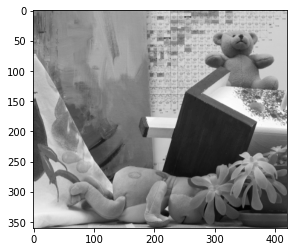

2.901837485804114e-10 2.919848780143867e-11


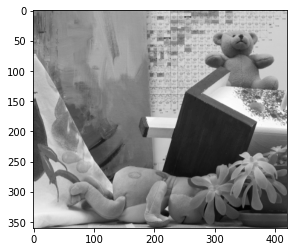

5.6444919048174486e-11 6.322450113932978e-12


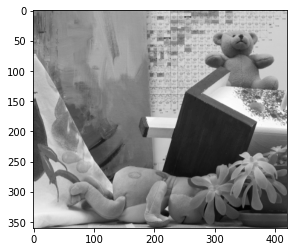

1.0971013487171012e-11 1.0978557661310742e-12


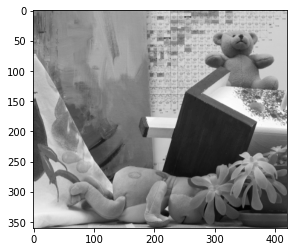

2.134329171619509e-12 2.438353896541572e-13


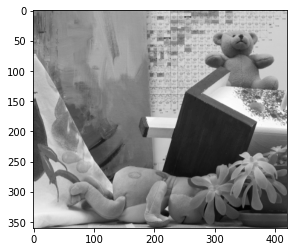

4.39831828422991e-13 3.365982024277591e-14


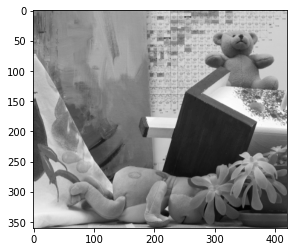

7.35794890883164e-14 1.1130197171635073e-14


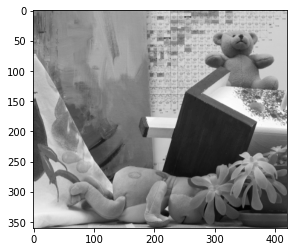

2.7982965048835236e-14 4.206065303776802e-15


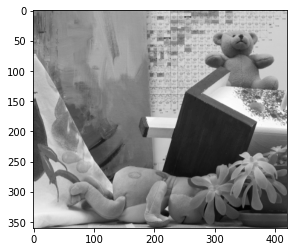

-1.8155346840292926e-14 -1.4699602906950638e-15


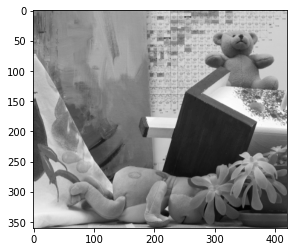

2.803741500617666e-14 3.828124278746877e-15


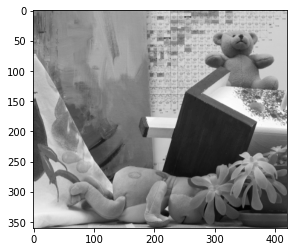

-1.8307850473558353e-14 -2.300230594925228e-15


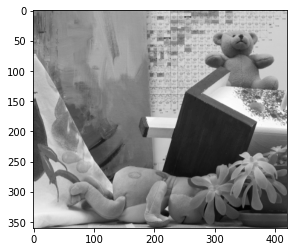

-1.8155346840292926e-14 -1.4699602906950638e-15


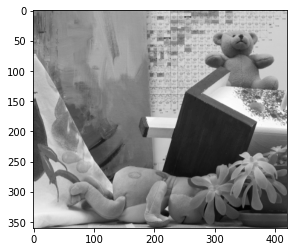

2.803741500617666e-14 3.828124278746877e-15


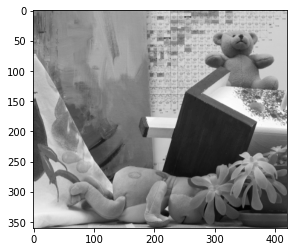

-1.8307850473558353e-14 -2.300230594925228e-15


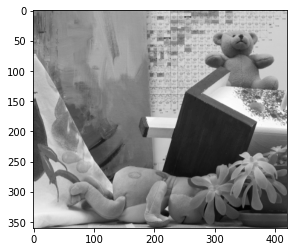

2.783321873693214e-14 -3.609900273799031e-15


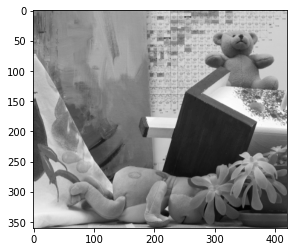

dx:  3.997347832812634
dy:  0.1765418230167782


In [ ]:
dx_sum = 0
dy_sum = 0
pt = (340, 45) # Teddy bear nose
#pt = (248, 134) # desk corner 
# TODO
win_size = ...
s = (win_size + 1) // 2
img1_win, img2_win = select_win([img1, img2], slice(pt[1]-s, pt[1]+s), slice(pt[0]-s, pt[0]+s))
for i in range(30):
    # TODO
    dx, dy = optical_flow(img1_win, img2_win, ..., ...)
    print(dx, dy)
    dx_sum += dx
    dy_sum += dy
    img2_shift = get_new_img(img2, dx_sum, dy_sum)
    plt.imshow(img2_shift, cmap='gray')
    plt.show()
    img2_win = select_win([img2_shift], slice(pt[1]-s, pt[1]+s), slice(pt[0]-s, pt[0]+s))[0]
print('dx: ', dx_sum)
print('dy: ', dy_sum)

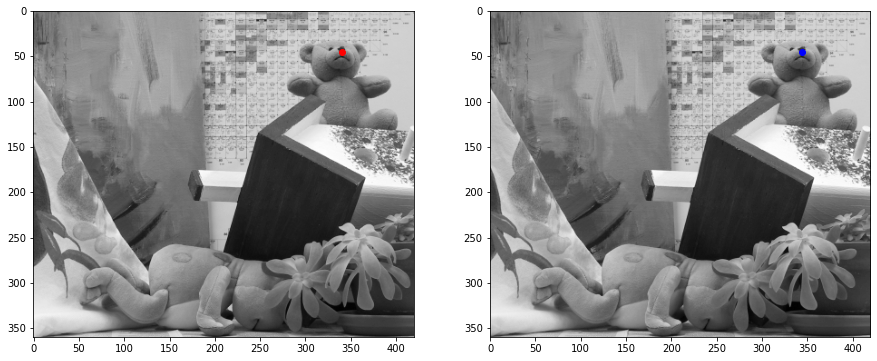

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15,15))
ax[0].imshow(img1, cmap='gray')
ax[0].plot(pt[0], pt[1], 'ro')
ax[1].imshow(img2, cmap='gray')
ax[1].plot(pt[0]+dx_sum, pt[1]+dy_sum, 'bo')

## Affine motion model optical flow estimation with PyTorch

In [ ]:
class Model(torch.nn.Module):
    def __init__(self):
        # TODO
        ...

    def forward(self, x):
        # TODO
        ...

In [ ]:
class OptflowData(Dataset):
    def __init__(self, A, b):
        # TODO
        ...
  
    def __len__(self):
        # TODO
        ...
    
    def __getitem__(self, idx):
        # TODO
        ...

In [ ]:
img = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 1, 1, 1, 0, 0, 0],
                [0, 0, 0, 1, 1, 1, 0, 0, 0],
                [0, 0, 0, 1, 1, 1, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0],
                ] )
img_next = np.array([
                     [0,   0,    0,   0,   0,   0,   0,   0,  0],
                     [0, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.25, 0],
                     [0, 0.5,   1,   1,    1,   1,   1, 0.5,  0],
                     [0, 0.5,   1,   1,    1,   1,   1, 0.5,  0],
                     [0, 0.5,   1,   1,    1,   1,   1, 0.5,  0],
                     [0, 0.5,   1,   1,    1,   1,   1, 0.5,  0],
                     [0, 0.5,   1,   1,    1,   1,   1, 0.5,  0],
                     [0, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.25, 0],
                     [0,   0,   0,   0,    0,   0,   0,   0,  0],
                     ] )

x, y = np.meshgrid(np.arange(img.shape[1]), np.arange(img.shape[0]))
x = x - img.shape[1] // 2
y = y - img.shape[0] // 2

fx = np.array([[1, 0, -1]])
fy = fx.T

# comment these two lines when using Gaussian blur
# Ix = convolve(img_next, fx, mode='same')
# Iy = convolve(img_next, fy, mode='same')

# uncomment following lines to use Gaussian blur 
G = cv2.getGaussianKernel(11, 30)
G = G @ G.T
Gx = convolve(G, fx, mode='same')
Gy = convolve(G, fy, mode='same')
Ix = convolve(img_next, Gx, mode='same')
Iy = convolve(img_next, Gy, mode='same')


It = img_next - img
A = np.c_[(Ix * x).ravel(), (Ix * y).ravel(), Ix.ravel(),
           (Iy * x).ravel(), (Iy * y).ravel(), Iy.ravel()]
b = (-It).ravel()

In [ ]:
model = Model()
dataset = OptflowData(A, b)
dataloader = DataLoader(dataset, batch_size=10)

In [ ]:
loss_fn = torch.nn.MSELoss()
opt = torch.optim.SGD(model.parameters(), lr=0.5)

In [ ]:
epoch = 1000
for i in range(epoch):
    loss_sum = 0
    for j, (x, y) in enumerate(dataloader):
        x, y = x.float(), y.float()
        # TODO
        ...
    print('epoch {}: {}'.format(i, loss_sum / j))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 0: 0.26930278885993175
epoch 1: 0.2513449600005515
epoch 2: 0.23909978471056093
epoch 3: 0.23065425496315584
epoch 4: 0.22475390473846346
epoch 5: 0.22057248081546277
epoch 6: 0.21756303869187832
epoch 7: 0.21536119491793215
epoch 8: 0.21372261689975858
epoch 9: 0.21248197904787958
epoch 10: 0.21152647235430777
epoch 11: 0.2107782531529665
epoch 12: 0.21018303791061044
epoch 13: 0.20970244193449616
epoch 14: 0.20930905500426888
epoch 15: 0.20898289186879992
epoch 16: 0.20870936987921596
epoch 17: 0.2084774747490883
epoch 18: 0.20827895682305098
epoch 19: 0.20810751663520932
epoch 20: 0.20795818185433745
epoch 21: 0.2078271359205246
epoch 22: 0.20771128591150045
epoch 23: 0.20760820154100657
epoch 24: 0.20751590933650732
epoch 25: 0.2074327846057713
epoch 26: 0.2073574976529926
epoch 27: 0.20728893135674298
epoch 28: 0.20722623774781823
epoch 29: 0.20716859749518335
epoch 30: 0.20711539220064878
epoch 31: 0.20706606283783913
epoch 32: 0.20702016912400723
epoch 33: 0.20697729382663

In [ ]:
res = model.fc.weight.detach().numpy().ravel()

In [ ]:
A_ = np.array([[res[0]+1, res[1]], [res[3], res[4]+1]])
b_ = np.array([res[2], res[5]])
print('A:', A_)
print('b:', b_)

A: [[ 2.85362732  0.66785437]
 [-1.56167054  1.28910276]]
b: [-0.8109869 -0.6534912]
